# Dr. Nuhfer's  Data Analysis

In [1]:
options(repr.plot.width=6, repr.plot.height=6)

## Introduction 


Dr. Nuhfer brings us a data set generated from a survey he designed.  You can get the raw data from [here](http://scholarcommons.usf.edu/numeracy/vol10/iss1/art4/).

**Survey Deisgn:** It includes a measure of demonstrated competence of science literacy from a test instrument and four measures of self-assessed competence, one as a composite score from a 25-item knowledge survey instrument and three from single questions. I rename the self-assessed competence as global_rating1, global_rating2, global_rating3 and actual_KSSLCI. 

Our client Dr. Nuhfer is interesting in the following questions:     
1.	Any other useful variables I should include in the survey? 
2.	Is the size of data large enough and representative?
3.	How to distinguish the participants who engaged in random guessing? 
4.	Does our data exhibit support for a Dunning-Kruger Effect in our study populace?
5.	Do our data support the contention that most people are overly optimistic? 
6.	Is there any evidence in our data that supports that experts are actually any better than novices in self-assessment?

In this data set, we have a total of 1154 observations and 82 variables. However, if we want to group some variables and evaluate each group, we may need more data to support that. For example, we don’t have enough observations who are professors and graduate students. 

## Data

In [57]:
# download or run the libraries 
require(dplyr) || install.packages("dplyr", repos='http://cran.us.r-project.org')
require(ggplot2) || install.packages("ggplot2", repos='http://cran.us.r-project.org')
require(kernlab) || install.packages("kernlab", repos='http://cran.us.r-project.org')
require(caret) || install.packages("caret", repos='http://cran.us.r-project.org')
require(e1071) || install.packages("e1071", repos='http://cran.us.r-project.org')
require(data.table) || install.packages("data.table")

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [3]:
##  read in and rename the data 
data <- read.csv("data.csv", header = TRUE, 
               stringsAsFactors = FALSE, 
               na.strings = c(""))
attach(data)

## rename some of the cols 

setnames(data, old = c('First.Generation.','Intent.to.Majorin..Science','Class.Rank',
                     'Courses.in.Science', 'English.as.First.Language',
                     'Global.rating.from.description.of.SLCI',
                     'From.Knowledge.survey.of.SLCI..KSSLCI.',
                     'Global.rating.informed.by.taking.KSSLCI',
                     'Actual.SLCI.Score',
                     'Global.rating.informed.after.taking.SLCI',
                     'KSSLCI.minus.SLCI', 'Item.Number'),
         new = c('first_generation','major_science', 'class_rank',
                 'courses_in_science','english_as_first_language',
                 'global_rating_1',
                 'actual_KSSLCI',
                 'global_rating_2',
                 'actual_SLCI','global_rating_3', 
                 'd', 'item_number'))

In [4]:
dim(data)

[1] 1154   82

### Cleaning 

In [5]:
# any missing value? 
sapply(data[, 51:68],function(x) sum(is.na(x)))

SLCI25 
                                       0 
                                  Gender 
                                       7 
                        first_generation 
                                       8 
                           major_science 
                                       4 
                              class_rank 
                                       5 
                      courses_in_science 
                                       5 
               english_as_first_language 
                                       5 
                               Ethnicity 
                                       0 
                             Institution 
                                       0 
                         global_rating_1 
                                       1 
                           actual_KSSLCI 
                                       0 
                         global_rating_2 
                                       1 
                             actual_SLCI 
                                       0 
                         global_rating_3 
                                     492 
                                       d 
                                       0 
                             item_number 
                                    1129 
   Collective.Average.SLCI.Score.by.item 
                                    1129 
Collective.Average.KSSLCI.rating.by.item 
                                    1129

In [6]:
# discard the rows without the record of gender, global_rating1 and 2, d, ...  
data <- data[!is.na(data$global_rating_1),]
data <- data[!is.na(data$global_rating_2),]
data <- data[!is.na(data$Gender),]
data <- data[!is.na(data$class_rank),]
data <- data[!is.na(data$courses_in_science),]
data <- data[!is.na(data$major_science),]
data <- data[!is.na(data$english_as_first_language),]
data <- data[!is.na(data$first_generation),]

# Ethnics 
non_sense_eth <- c("0%")
data <- data[ ! data$Ethnicity %in% non_sense_eth, ]

**drop them**   
Gender 7   
class_rank 5                         
courses_in_science 5   
major_science 4  
english_as_first_language 5  
first_generation 8   
global_rating_1 1   
global_rating_2 1   

**not necessary to drop**  
global_rating_3 492   

### Recoding

In [7]:
# 1.0% to 0.01
data$actual_SLCI <- as.numeric(sub("%","", data$actual_SLCI))/100

# global_rating_1
data$global_rating_1 <- as.numeric(sub("%","", data$global_rating_1))/100

# global_rating_2
data$global_rating_2 <- as.numeric(sub("%","", data$global_rating_2))/100

# global_rating_3
data$global_rating_3 <- as.numeric(sub("%","", data$global_rating_2))/100

# data$actual_KSSLCI
data$actual_KSSLCI <- as.numeric(sub("%","", data$actual_KSSLCI))/100

# d
data$d <- as.numeric(sub("%","", data$d))/100


In [8]:
data_new <- data[,52:82]

#### Gender 

Female => 0        
Male => 1 

In [9]:
## recode Gender
data_new$Gender[data_new$Gender == "Female"] <- 0
data_new$Gender[data_new$Gender == "Male"] <- 1

#### class_rank

"Freshman" = 1      
"Sophomore" = 2    
"Junior" = 3        
"Senior" = 4                         
"Grad Student" = 5      
"Professor" = 6  

In [10]:
data_new$class_rank[data_new$class_rank == "Freshman"] <- 1
data_new$class_rank[data_new$class_rank == "Sophomore"] <- 2
data_new$class_rank[data_new$class_rank == "Junior"] <- 3
data_new$class_rank[data_new$class_rank == "Senior"] <- 4
data_new$class_rank[data_new$class_rank == "Grad Student"] <- 5
data_new$class_rank[data_new$class_rank == "Professor"] <- 6

#### major_science

Science Major = 1     
Not Science Major = 0 

In [11]:
data_new$major_science[data_new$major_science == "Yes"] <- 1
data_new$major_science[data_new$major_science == "No"] <- 0

table(data_new$major_science)  
# We have 375 students with science major and 757 students with non-science major. 


  0   1 
374 751 

##### courses_in_science

None => 1
One => 2
Two => 3
Three => 4
Four => 5
More than four => 6

In [12]:
data_new$courses_in_science[data_new$courses_in_science == "None"] <- 1
data_new$courses_in_science[data_new$courses_in_science == "One"] <- 2
data_new$courses_in_science[data_new$courses_in_science == "Two"] <- 3
data_new$courses_in_science[data_new$courses_in_science == "Three"] <- 4
data_new$courses_in_science[data_new$courses_in_science == "Four"] <- 5
data_new$courses_in_science[data_new$courses_in_science == "More than four"] <- 6

##### english_as_first_language

Yes => 1
No => 0

In [13]:
data_new$english_as_first_language[data_new$english_as_first_language == "Yes"] <- 1
data_new$english_as_first_language[data_new$english_as_first_language == "No"] <- 0

##### Ethnicity

In [14]:
table(data_new$Ethnicity)


African/African-American                    Asian          Caucasian/White 
                      38                       53                      696 
     Hispanic/Chicano(a)           Middle Eastern          Native American 
                     241                       13                        7 
                   Other         Pacific Islander 
                      70                        7 

Caucasian/White => 1     
Asian => 2      
African/African-American => 3      
Hispanic/Chicano(a) => 4      
Native American => 5    
Pacific Islander => 6    
Middle Eastern => 7      
Other => 8        

In [15]:
data_new$Ethnicity[data_new$Ethnicity == "Caucasian/White"] <- 1
data_new$Ethnicity[data_new$Ethnicity == "Asian"] <- 2
data_new$Ethnicity[data_new$Ethnicity == "African/African-American"] <- 3
data_new$Ethnicity[data_new$Ethnicity == "Hispanic/Chicano(a)"] <- 4
data_new$Ethnicity[data_new$Ethnicity == "Native American"] <- 5
data_new$Ethnicity[data_new$Ethnicity == "Pacific Islander"] <- 6
data_new$Ethnicity[data_new$Ethnicity == "Middle Eastern"] <- 7
data_new$Ethnicity[data_new$Ethnicity == "Other"] <- 8

##### Institution

In [16]:
table(data_new$Institution)

data_new$Institution[data_new$Institution == "Institution A"] <- 1
data_new$Institution[data_new$Institution == "Institution B"] <- 2
data_new$Institution[data_new$Institution == "Institution C"] <- 3
data_new$Institution[data_new$Institution == "Institution D"] <- 4
data_new$Institution[data_new$Institution == "Institution E"] <- 5
data_new$Institution[data_new$Institution == "Institution F"] <- 6
data_new$Institution[data_new$Institution == "Conference G"] <- 7
data_new$Institution[data_new$Institution == "Conference H"] <- 8
data_new$Institution[data_new$Institution == "Conference I"] <- 9
data_new$Institution[data_new$Institution == "Conference J"] <- 10
data_new$Institution[data_new$Institution == "Institution K"] <- 11
data_new$Institution[data_new$Institution == "Conference L"] <- 12


 Conference G  Conference H  Conference I  Conference J  Conference L 
           10             2            21            19            24 
Institution A Institution B Institution C Institution D Institution E 
          504             1            22           414            63 
Institution F Institution K 
           11            34 

I find that 504 observations are from Institution A and 414 students are from Institution D. The rest of institutions has only less than 100 observations. I suspect that it may cause some bias in our model. 

##### first_generation

In [17]:
data_new$first_generation[data_new$first_generation == "Yes"] <- 1
data_new$first_generation[data_new$first_generation == "No"] <- 0

### Short Summary 

In [18]:
data_new %>% dim()
tail(data_new)

[1] 1125   31

,Gender,first_generation,major_science,class_rank,courses_in_science,english_as_first_language,Ethnicity,Institution,global_rating_1,actual_KSSLCI,...,Random..KSSLCI.as.Percentile,Random...KSSLCI.SLCI..as.percentile,SLCI.Percentile,KSSLCI.Percentile,ksslci...slci.percentile,Quartile,ksslci.slci.ppts,SLCI.percentile.x.100,ksslcipercentile.x.100,ksslci.slcipercentile.x.100
1149,1,1,0,4,4,0,4,11,0.75,0.48,...,0.88725,0.0867,0.55507,0.12229,-0.43278,3rd,-32,55.507,12.229,-43.278
1150,1,0,1,4,6,1,2,11,0.45,0.68,...,0.99653,0.1587,0.95490,0.33304,-0.62186,Top,-28,95.490,33.304,-62.186
1151,1,1,1,4,6,1,1,11,0.70,0.40,...,0.49176,0.3417,0.39115,0.07112,-0.32003,2nd,-32,39.115,7.112,-32.003
1152,0,0,0,3,3,1,2,11,0.50,0.82,...,0.92368,-0.0746,0.32003,0.55160,0.23157,2nd,14,32.003,55.160,23.157
1153,0,1,0,4,6,1,2,11,0.80,0.80,...,0.77450,0.5707,0.55594,0.50737,-0.04857,3rd,0,55.594,50.737,-4.857
1154,0,1,1,4,6,1,1,11,0.80,0.64,...,0.96357,0.6461,0.55681,0.28621,-0.27060,3rd,-16,55.681,28.621,-27.060


After cleaning and recoding, the data frame has 1125 variables.              
Here is a glimpse of the data frame. 

## Approach

1.	**Cleaning the data and recoding the variables**         
Since I will use all the demographic variables, from gender to institution, I drop the observations with any missing value in these columns. The total number of observations after cleaning is 1125. I also recode the categorical variables to numeric numbers. It not only accelerates the computation, but also makes later machine learning normalization easier.
2.	**Explore some important variables**, such as gender, class rank, science major and institution. Check if that variable is significant.
3.	**Machine Learning Method: SVM**


## Analysis: 

### $d_i$ 

Rather than compare the participant’s overall guess as to what % they will get correct to the % they actually got correct and using the difference between these two numbers, we found the the difference in what each person thought they’d get for a question with what they actually got on that question

I create two matrixes, one for the knowledge test records(K) and the other for the actual test records (S). I use the above method to create d_i=S-K/2. Then, we calculate the mean of all d_i and obtain that individual’s dif_bar. If the dif_bar is smaller than 0, we can say that he/she overestimate themselves. If that person’s dif_bar is higher than 0, we can say that he/she overestimate themselves. This method is different from Dr. Nuhfer’s way of calculating d. It decreases many noises in the process. 

**Breakdown of the Matrix:**

|     |                  | S                           |
|:---:|------------------|---------------|-------------|
|     |                  | 0 = INCORRECT | 1 = CORRECT |
|     | 0 = DON'T KNOW   | 0             | 1           |
| K/2 | 0.5 = MIGHT KNOW | -0.5          | 0.5         |
|     | 1 = KNOW IT      | -1            | 0           |


If you’re accurate, then your difference is 0 and the more inaccurate you are the closer you get to 1 or -1       
**(positive # = underestimate, negative # = overestimate)**


Then we averaged this difference for each question for each individual and use the individual average differences to gather information for this group of individuals


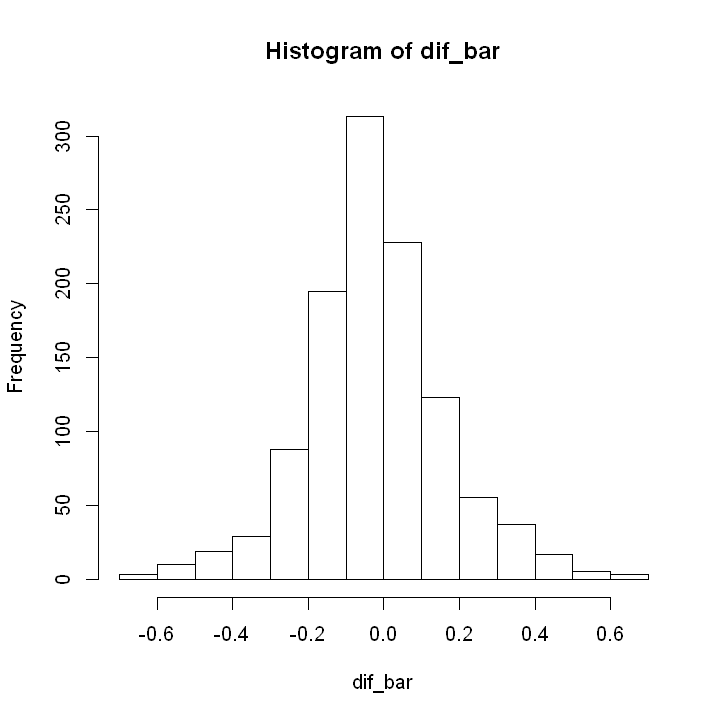

In [19]:
NN <- dim(data)[1]

K_test_mat <- as.matrix(data[, 2:26])
S_test_mat <- as.matrix(data[, 27:51])

# calculate di: S - 0.5K
dif_score_mat <- matrix(0, NN, 25)
dif_score_mat <- S_test_mat - 0.5*K_test_mat

dif_bar <- apply(dif_score_mat, 1, mean, na.rm = TRUE)
data_new$dif_bar <- dif_bar

hist(dif_bar)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-0.64000 -0.12000 -0.02000 -0.01164  0.08000  0.66000 

[1] 0.184097

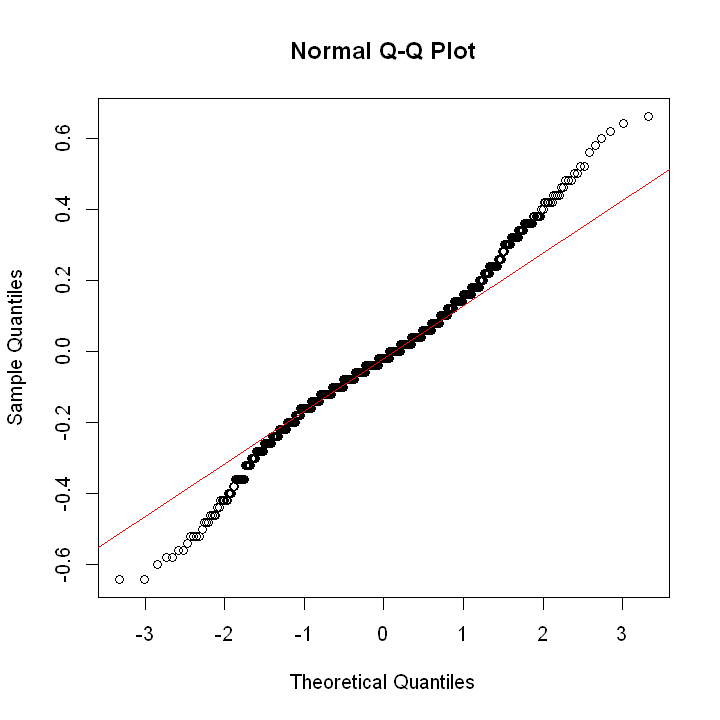

In [20]:
summary(dif_bar)
qqnorm(dif_bar)
qqline(dif_bar, col = "red")

sd(dif_bar)

The qq plot does not look like a straight line. It means that the linear assumption is not met. 

Since the qq plot for dif_bar doesn’t look good, we use bootstrap to sample 1000 points from the data and draw another histogram. From the histogram, we can see that the mean is around -0.01. We can conclude together with the t test that people are more likely to overestimate themselves.  It answers the fifth question that our client asked. 

### BootStrap 

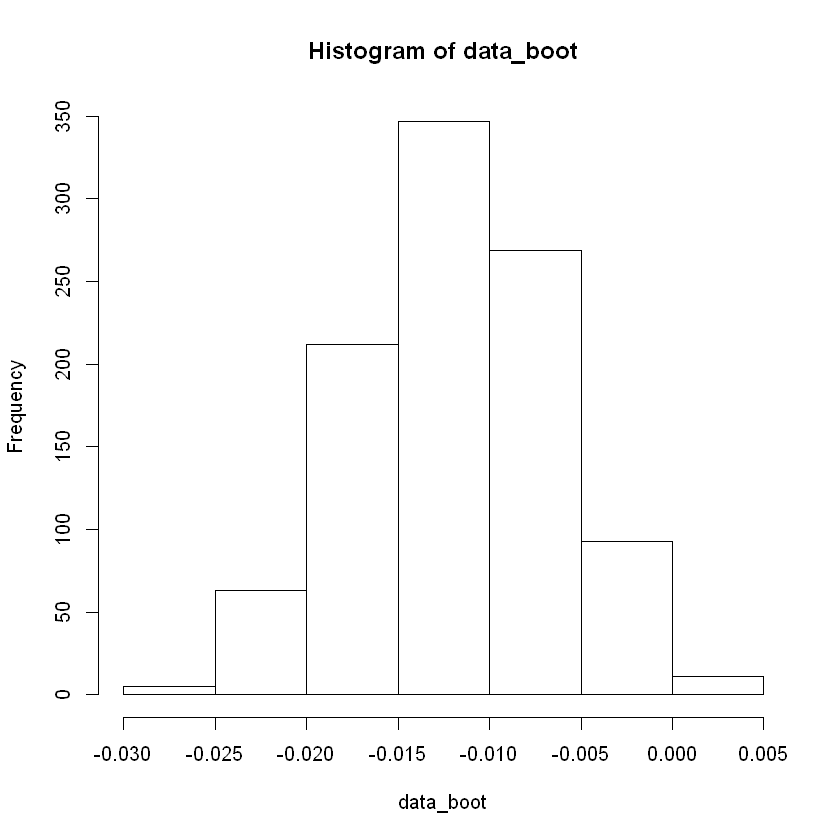

In [1]:
## boostrap 
nboot <- 1000
data_boot <- rep(0,nboot)

for (i in 1:nboot) {
  boot_sample <- sample(data_new$dif_bar, NN, replace = TRUE)
  data_boot[i] <- mean(boot_sample, na.rm = TRUE)
}



hist(data_boot)

### Test for Dunning-Kruger Effect

$H_0$: $\mu = 0$       
$H_a$: $\mu < 0$

In [21]:
# One sample t test 
xbar_dif_bar <- mean(data_new$dif_bar)
t.test(data_new$dif_bar, mu = xbar_dif_bar, alternative = "less")


	One Sample t-test

data:  data_new$dif_bar
t = 0, df = 1124, p-value = 0.5
alternative hypothesis: true mean is less than -0.01164444
95 percent confidence interval:
         -Inf -0.002608872
sample estimates:
  mean of x 
-0.01164444 



Call:
lm(formula = data_new$actual_SLCI ~ data_new$dif_bar, data = data_new)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.59039 -0.12098  0.04745  0.15078  0.26019 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.739806   0.005469  135.28   <2e-16 ***
data_new$dif_bar 0.421543   0.029659   14.21   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1831 on 1123 degrees of freedom
Multiple R-squared:  0.1525,	Adjusted R-squared:  0.1517 
F-statistic:   202 on 1 and 1123 DF,  p-value: < 2.2e-16


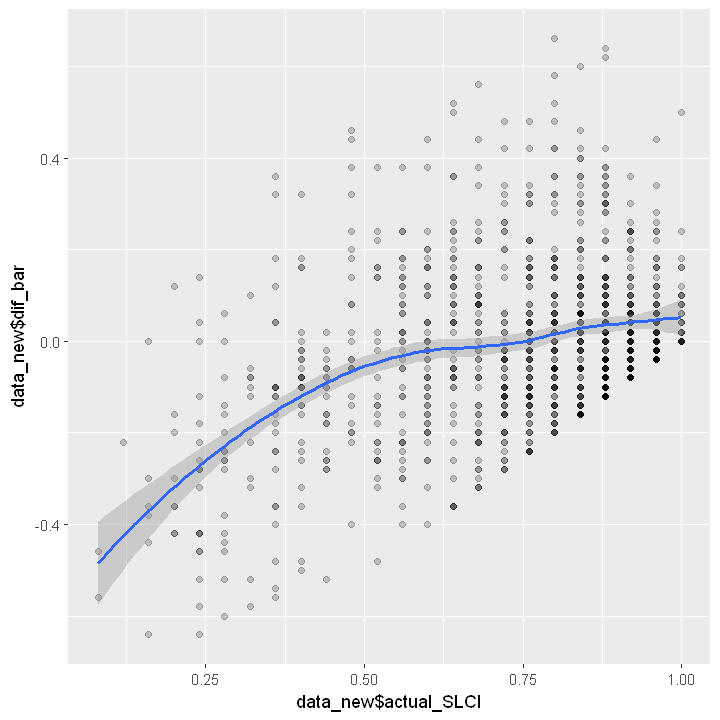

In [22]:
fit_d_actual_SLCI <- lm(data_new$actual_SLCI~data_new$dif_bar, data = data_new)

ggplot(aes(x = data_new$actual_SLCI, y = data_new$dif_bar), data = data_new) +
  geom_point(alpha = 0.2) + 
  geom_smooth(method = 'loess')

summary(fit_d_actual_SLCI)  # p value is smaller than 2.2e-16 

### Gender vs. $\bar{d}$

In [23]:
dif_bar_m <- data_new$dif_bar[data_new$Gender == 1]
dif_bar_f <- data_new$dif_bar[data_new$Gender == 0]
mean_dif_bar_m <- mean(dif_bar_m)
mean_dif_bar_f <- mean(dif_bar_f)

df_gender <- data_new %>% 
  group_by(Gender) %>% 
  summarise(mean_dif_bar = mean(dif_bar),
            sd_dif_bar = sd(dif_bar),
            min_dif_bar = min(dif_bar),
            median_dif_bar = median(dif_bar),
            max_dif_bar = max(dif_bar),
            n = n())

head(df_gender)

Gender,mean_dif_bar,sd_dif_bar,min_dif_bar,median_dif_bar,max_dif_bar,n
0,0.006227209,0.1882009,-0.54,0.00,0.66,713
1,-0.042572816,0.1726681,-0.64,-0.04,0.64,412


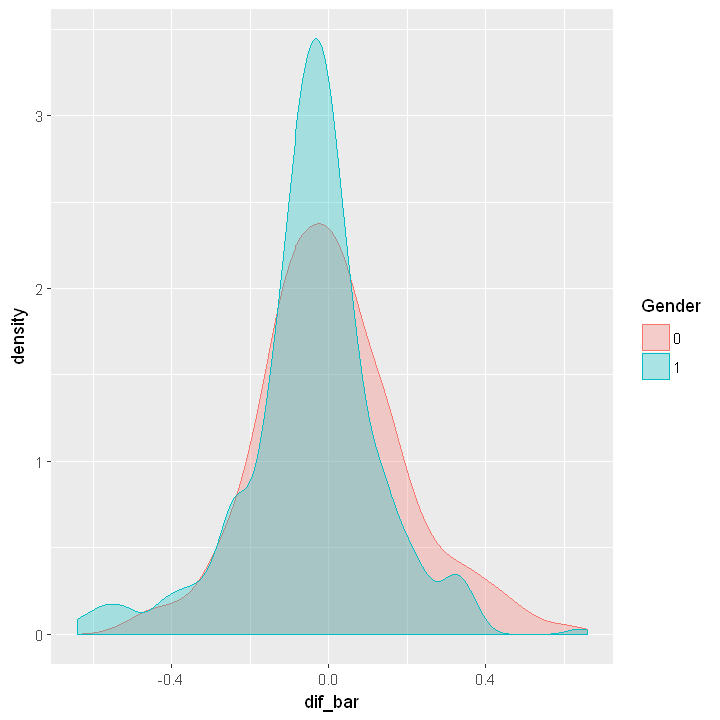

In [24]:
density_gender <- ggplot(data_new, aes(dif_bar, colour=Gender, fill=Gender))
density_gender  <- density_gender + geom_density(alpha=0.3)
density_gender

**Gender dif_bar: Is the difference significant ? **       
$H_0$: $\mu_M = \mu_F$     
$H_a$: $\mu_M \neq \mu_F$    

In [25]:
# two sample t test 
t.test(dif_bar_m, dif_bar_f,
       alternative = "two.sided", var.equal=TRUE)


	Two Sample t-test

data:  dif_bar_m and dif_bar_f
t = -4.3169, df = 1123, p-value = 1.722e-05
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07098022 -0.02661983
sample estimates:
   mean of x    mean of y 
-0.042572816  0.006227209 


p-value = 1.911e-05 is very small. 

Hence, the dif_bar between male and female is statistically significant at 95% considence level.

### Class_rank vs. $\bar{d}$

In [26]:
data_new$class_rank[data_new$class_rank == "Freshman"] <- 1
data_new$class_rank[data_new$class_rank == "Sophomore"] <- 2
data_new$class_rank[data_new$class_rank == "Junior"] <- 3
data_new$class_rank[data_new$class_rank == "Senior"] <- 4
data_new$class_rank[data_new$class_rank == "Grad Student"] <- 5
data_new$class_rank[data_new$class_rank == "Professor"] <- 6

df_class_rank <- data_new %>% 
  group_by(class_rank) %>% 
  summarise(mean_dif_bar = mean(dif_bar),
            sd_dif_bar = sd(dif_bar),
            min_dif_bar = min(dif_bar),
            median_dif_bar = median(dif_bar),
            max_dif_bar = max(dif_bar),
            n = n()) 

head(df_class_rank)

class_rank,mean_dif_bar,sd_dif_bar,min_dif_bar,median_dif_bar,max_dif_bar,n
1,-0.02449761,0.1917251,-0.60,-0.04,0.64,209
2,-0.01393939,0.1962819,-0.64,-0.02,0.52,231
3,-0.01448276,0.1853485,-0.64,-0.02,0.62,261
4,-0.01493750,0.1749465,-0.54,-0.02,0.56,320
5,0.04871795,0.2095506,-0.30,0.00,0.66,39
6,0.02923077,0.1206274,-0.20,0.00,0.34,65


"Freshman" = 1      
"Sophomore" = 2    
"Junior" = 3        
"Senior" = 4                         
"Grad Student" = 5      
"Professor" = 6       

In [27]:
dif_bar_Freshman <- data_new$dif_bar[data_new$class_rank == 1]
dif_bar_Senior <- data_new$dif_bar[data_new$class_rank == 2]
dif_bar_Sophomore <- data_new$dif_bar[data_new$class_rank == 3]
dif_bar_Junior <- data_new$dif_bar[data_new$class_rank == 4]
dif_bar_Professor <- data_new$dif_bar[data_new$class_rank == 6]
dif_bar_GradStudent <- data_new$dif_bar[data_new$class_rank == 5]

Warning message in bxp(structure(list(stats = structure(c(-0.46, -0.16, -0.03, 0.06, :
"some notches went outside hinges ('box'): maybe set notch=FALSE"

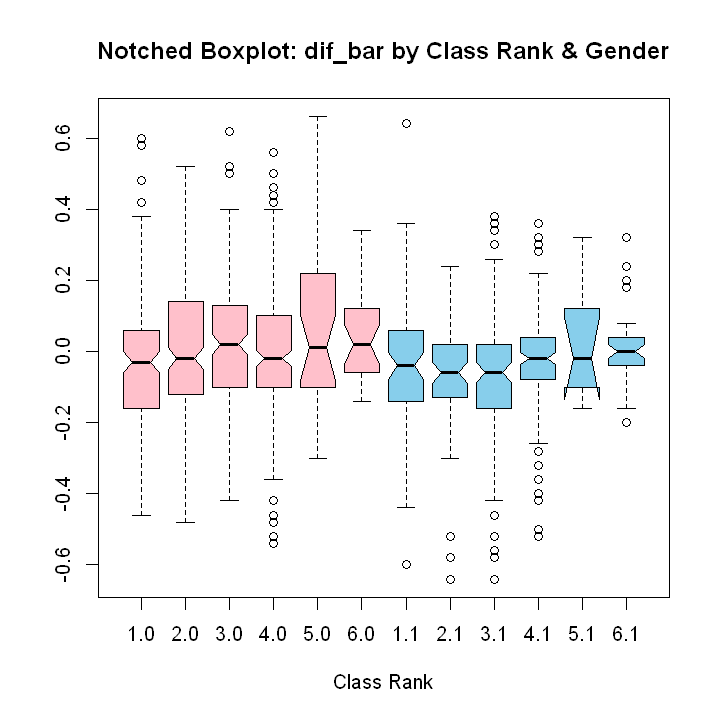

In [28]:
boxplot(dif_bar~class_rank*Gender, 
        data = data_new, notch=TRUE, 
  col = (c("pink","pink","pink","pink","pink","pink", "skyblue","skyblue","skyblue","skyblue","skyblue","skyblue")),
  main="Notched Boxplot: dif_bar by Class Rank & Gender",
  xlab = "Class Rank")

From the boxplot, we can easily see that the female students are more likely to underestimate themselves. We found more male students who overestimate their score a lot, while several more female students much underestimate their scores. It is interesting to see that we have female senior students who much underestimate their scores as well as much overestimate their scores.           

We don’t have enough data to support that the professors and graduate students have significant difference in gender due to the lack of data. 


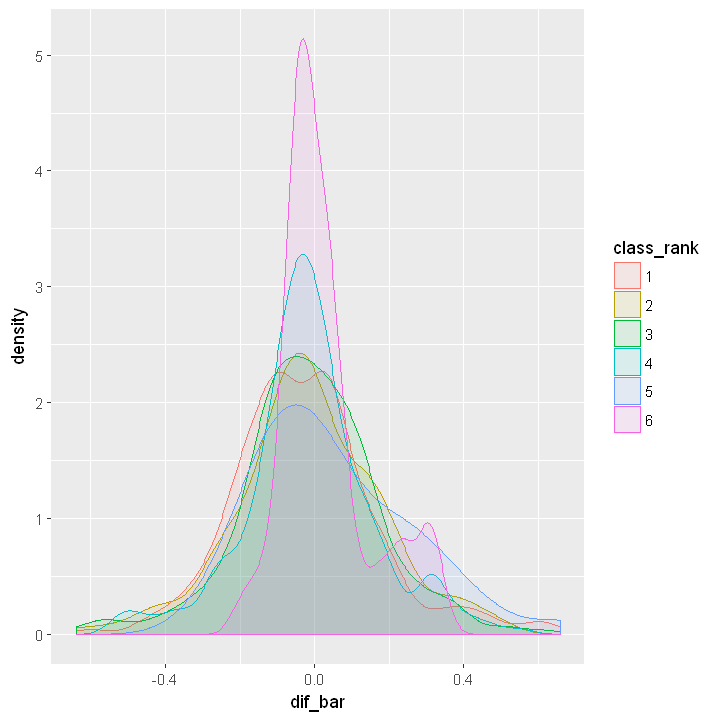

In [29]:
density_class_rank  <- ggplot(data_new, aes(dif_bar, colour=class_rank, fill=class_rank))
density_class_rank  <- density_class_rank + geom_density(alpha=0.1)
density_class_rank

#### Comparing Undergraduate Students 

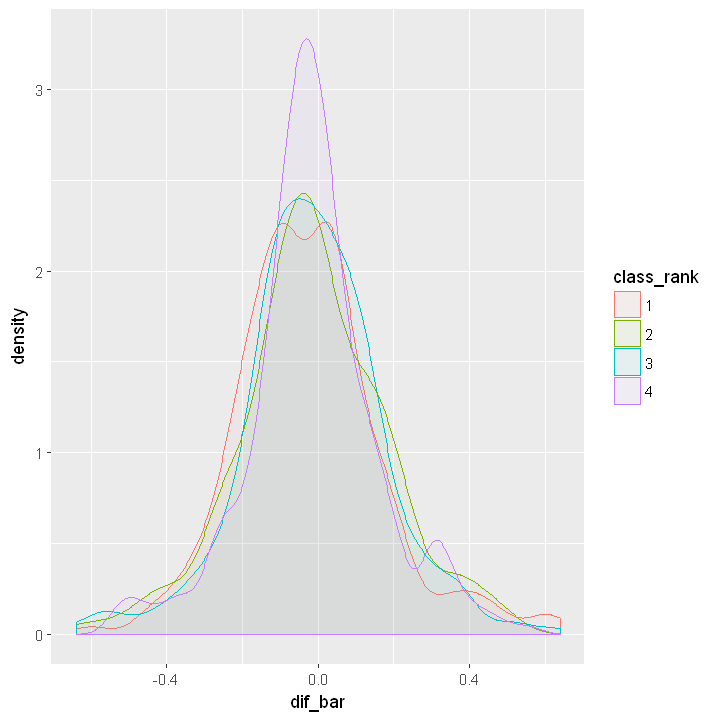

In [30]:
compare1 <- c(1, 2, 3, 4)
compare1_df <- subset(data_new, class_rank %in% compare1)

density_class_rank  <- ggplot(compare1_df, aes(dif_bar, colour=class_rank, fill=class_rank))
density_class_rank  <- density_class_rank + geom_density(alpha=0.05)
density_class_rank

This density plot is more persuasive since we have enough data of undergraduate students. 

We have enough data records for all four years of undergraduate students. Hence, the distribution of dif_bar for the undergraduate students is more persuasive than graduate students and professors. From the density plot above, we can see that the fourth-year students have a more distinguish distribution than the other three levels’. We also observe a small peak on the bottom-left of the graph. It indicates that the senior students are more likely to get a correct estimation than the other three levels. 

#### Comparing the 1st, 2nd year with the professors (huge difference) 

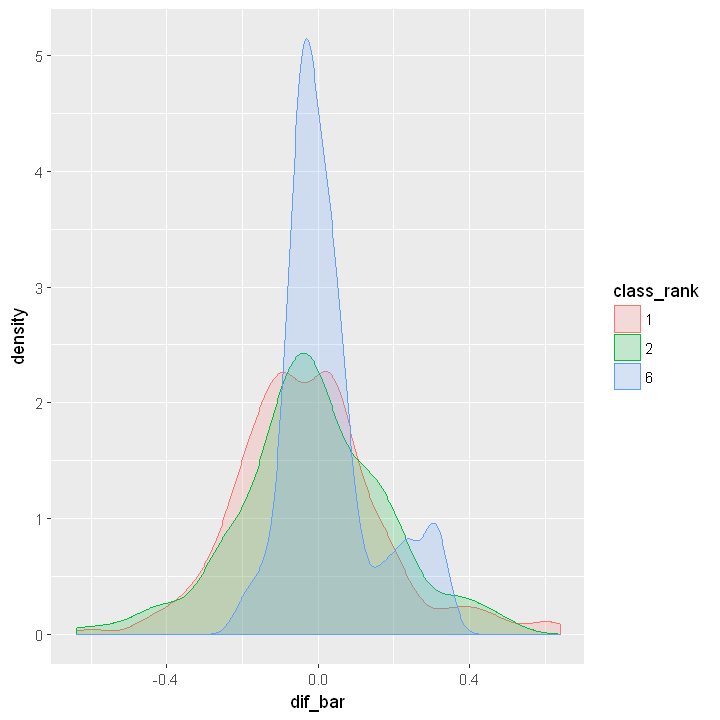

In [31]:
compare2 <- c(1, 2, 6)
compare2_df <- subset(data_new, data_new$class_rank %in% compare2)

density_class_rank  <- ggplot(compare2_df, aes(dif_bar, colour=class_rank, fill=class_rank))
density_class_rank  <- density_class_rank + geom_density(alpha=0.20)
density_class_rank

### Gender + Class_rank vs. $\bar{d}$

In [32]:
df_class_gender <- data_new %>% 
  group_by(class_rank, Gender) %>% 
  summarise(mean_dif_bar = mean(dif_bar)) 

head(df_class_gender)

class_rank,Gender,mean_dif_bar
1,0,-0.017826087
1,1,-0.037464789
2,0,0.006783626
2,1,-0.073000000
3,0,0.024250000
3,1,-0.075841584


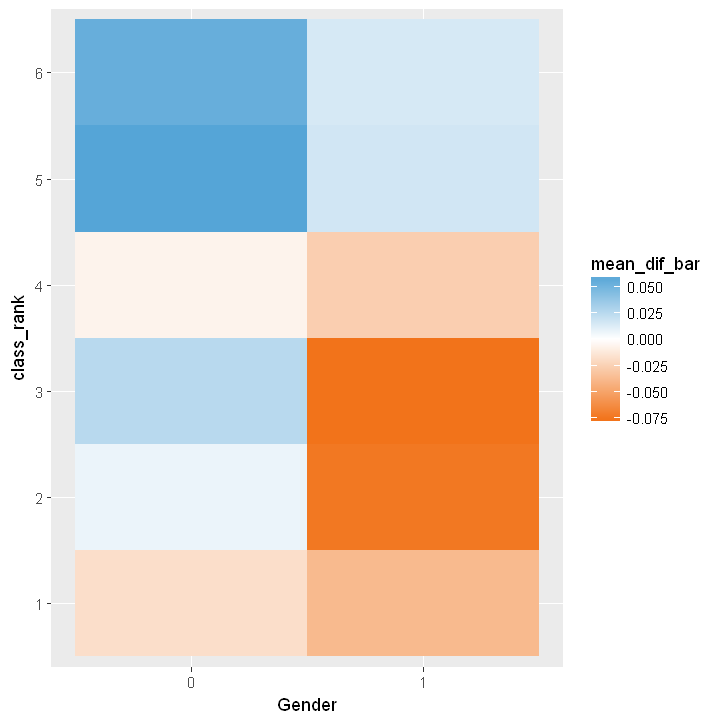

In [33]:
heatmap_class_gender <- ggplot(data = df_class_gender, 
       aes(x = Gender, y = class_rank)) +
  geom_tile(aes(fill = mean_dif_bar)) 

#set up a coloring scheme using colorRampPalette
# x <- 1:255/255
# c(x[34],x[143],x[200])    # test color 
red=rgb(0.95,0.45,0.1); green=rgb(0,1,0); blue=rgb(0.15,0.55,0.8); white=rgb(1,1,1); black=rgb(0,0,0)

RtoWrange<-colorRampPalette(c(red, white ))
WtoGrange<-colorRampPalette(c(white, blue)) 

heatmap_class_gender <- heatmap_class_gender + 
  scale_fill_gradient2(low=RtoWrange(100), mid=WtoGrange(100), high="gray")
heatmap_class_gender

The orange color represents that people in that group overestimate themselves, and the blue color represents that people in that group underestimate themselves. The saturation of colors represents the level of the over or under estimation. 

From the heatmap, we can easily find that the second and third year male students are more likely to overestimate themselves. I hesitate to conclude that the female professors and female graduate students are more likely to underestimate themselves since we don't have lots of data to support it. Moreover, since their scores are pretty high, they have less room to overestimate themselves.


### major_science

In [34]:
dif_bar_1 <- data_new$dif_bar[data_new$major_science == 1]
dif_bar_2 <- data_new$dif_bar[data_new$major_science == 0]

mean_dif_bar_1 <- mean(dif_bar_1, na.rm = TRUE)
mean_dif_bar_2 <- mean(dif_bar_2, na.rm = TRUE)

In [35]:
df_major_science <- data_new %>% 
  group_by(major_science) %>% 
  summarise(mean_dif_bar = mean(dif_bar),
            sd_dif_bar = sd(dif_bar),
            min_dif_bar = min(dif_bar),
            median_dif_bar = median(dif_bar),
            max_dif_bar = max(dif_bar),
            n = n())

head(df_major_science)

major_science,mean_dif_bar,sd_dif_bar,min_dif_bar,median_dif_bar,max_dif_bar,n
0,0.01245989,0.1972406,-0.60,0.00,0.66,374
1,-0.02364847,0.1760970,-0.64,-0.02,0.64,751


Major_science dif bar test: is the difference sig ?   
$H_0$: $\mu_1 = \mu_0$    
$H_a$: $\mu_1 \neq \mu_0$      

In [36]:
# two sample t test 
t.test(dif_bar_1, dif_bar_2,
       alternative = "two.sided", var.equal=TRUE)


	Two Sample t-test

data:  dif_bar_1 and dif_bar_2
t = -3.1111, df = 1123, p-value = 0.001911
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05888100 -0.01333573
sample estimates:
  mean of x   mean of y 
-0.02364847  0.01245989 


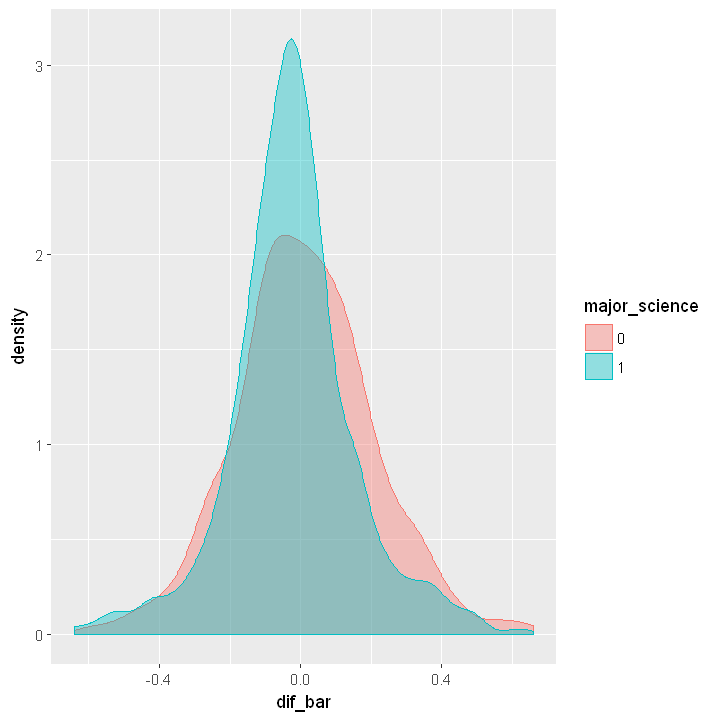

In [37]:
density_major_science <- ggplot(data_new, aes(dif_bar, colour=major_science, fill=major_science))
density_major_science  <- density_major_science + geom_density(alpha=0.4)
density_major_science

### Institution 

In [38]:
df_institution <- data_new %>% 
  group_by(Institution) %>% 
  summarise(mean_dif_bar = mean(dif_bar),
            sd_dif_bar = sd(dif_bar),
            min_dif_bar = min(dif_bar),
            median_dif_bar = median(dif_bar),
            max_dif_bar = max(dif_bar),
            n = n()) %>% 
    arrange(desc(n))

df_institution2 <- data_new %>% 
  group_by(Institution) %>% 
  filter(Institution == 1 | Institution == 5 | Institution == 4) %>% 
  summarise(mean_dif_bar = mean(dif_bar),
            sd_dif_bar = sd(dif_bar),
            min_dif_bar = min(dif_bar),
            median_dif_bar = median(dif_bar),
            max_dif_bar = max(dif_bar),
            n = n()) %>% 
    arrange(desc(n))

head(df_institution)
head(df_institution2)

Institution,mean_dif_bar,sd_dif_bar,min_dif_bar,median_dif_bar,max_dif_bar,n
1,-0.043174603,0.1667925,-0.64,-0.04,0.60,504
4,-0.002077295,0.2022118,-0.64,-0.02,0.62,414
5,0.046349206,0.1760801,-0.36,0.02,0.64,63
11,0.030000000,0.1786312,-0.36,0.03,0.46,34
12,-0.005000000,0.1518867,-0.30,-0.01,0.28,24
3,0.093636364,0.1686231,-0.26,0.08,0.42,22


Institution,mean_dif_bar,sd_dif_bar,min_dif_bar,median_dif_bar,max_dif_bar,n
1,-0.043174603,0.1667925,-0.64,-0.04,0.60,504
4,-0.002077295,0.2022118,-0.64,-0.02,0.62,414
5,0.046349206,0.1760801,-0.36,0.02,0.64,63


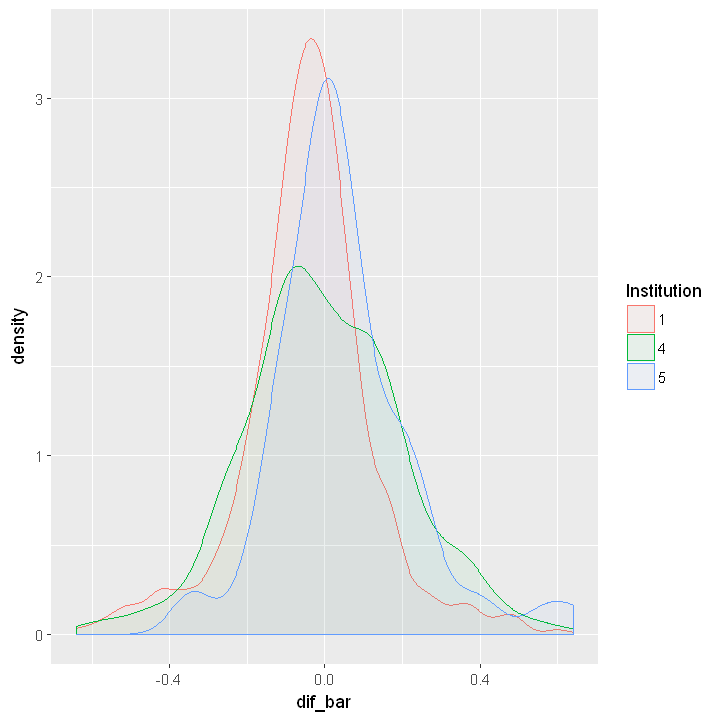

In [39]:
density_institution2 <- ggplot(data_new[which (data_new$Institution == 1 | data_new$Institution == 4 | data_new$Institution == 5),], 
                               aes(dif_bar, colour= Institution, fill = Institution))
density_institution2  <- density_institution2 + geom_density(alpha=0.05)
density_institution2

Since we only have over 63 observations for these three institutions, I think it makes sense to only plot them three. The density plot above indicates that Institution E has a very different distribution comparing to Institution A and D. It may worth digging the reason behind it. 

In [40]:
df_gender_insti <- data_new %>% 
  group_by(Institution, Gender) %>% 
  summarise(mean_dif_bar = mean(dif_bar)) 

head(df_gender_insti)

Institution,Gender,mean_dif_bar
1,0,-0.027075812
1,1,-0.062819383
10,0,0.036666667
10,1,0.041538462
11,0,-0.002857143
11,1,0.083076923


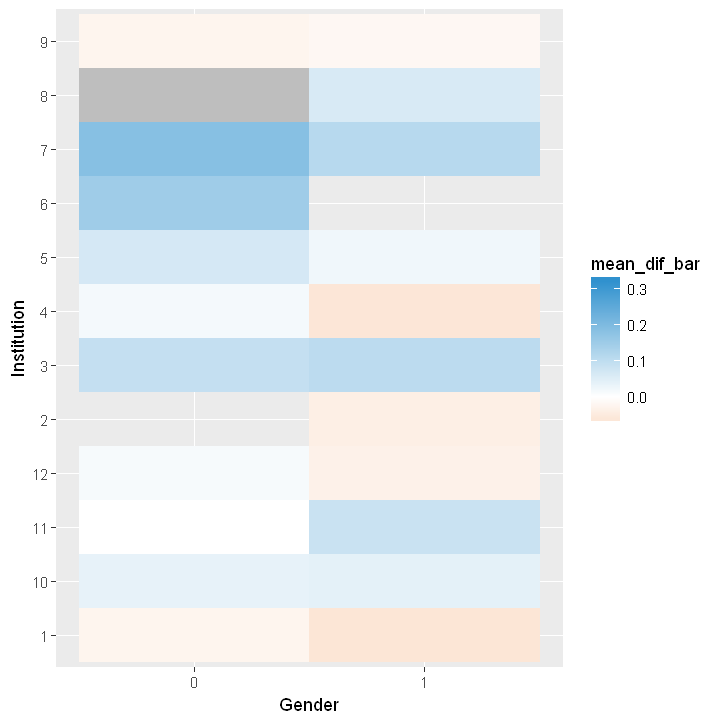

In [41]:
heatmap_gender_insti <- ggplot(data = df_gender_insti, 
       aes(x = Gender, y = Institution)) +
  geom_tile(aes(fill = mean_dif_bar)) 

#set up a coloring scheme using colorRampPalette
# x <- 1:255/255
# c(x[34],x[143],x[200])    # test color 
red=rgb(0.95,0.45,0.1); green=rgb(0,1,0); blue=rgb(0.15,0.55,0.8); white=rgb(1,1,1); black=rgb(0,0,0)

RtoWrange<-colorRampPalette(c(red, white ))
WtoGrange<-colorRampPalette(c(white, blue)) 

heatmap_gender_insti <- heatmap_gender_insti + 
  scale_fill_gradient2(low=RtoWrange(100), mid=WtoGrange(100), high="gray")

heatmap_gender_insti

Also, our client mentioned that the institution may play a role in the mean of differences. Hence, I create another heatmap to observe the two gender groups in each institution. 

It is interesting to find that we don't have any group that typically overestimate themselves. The male students in the Institution 4 and Institution 1 slightly overestimate their ability. It is also interesting to see that Institution A is the only school that has both male and female students overestimate themselves.


### Random guessing 

We will get 25% correct for the test if we do the random guessing.  
Upper Tail test     
$H_0: p <= 0.25$      
$H_a: p > 0.25$      


In [42]:
sd = sqrt(3/4*1/4)/25
xbar_randguess = mean(data_new$actual_SLCI) 
t_statistics = (xbar_randguess - 0.25)/(sd/sqrt(NN))  # < 1.646
alpha = .05 
t_alpha = qt(1−alpha, df=NN−1) 

sd = 0.0173      
xbar_randguess = 0.7354
t_statistics = 943.822  
t_alpha = 1.6461     

The test statistic 943.8222 is greater than the critical value of 1.6462 Hence, at .05 significance level, we can reject the null hypothesis. The propobility is higher than 25%. It doesn't indicate random guessing. 

### First 10 questions vs. Last 10 questions 

When I was doing the survey, I gradually lost my patience after finishing the first ten questions. I think it may be interesting to see if there is a significant difference between the first 10 and the last 10 questions. I drop the middle 5 question because the 15th question is a pretty tough one. It may cast some bias. 

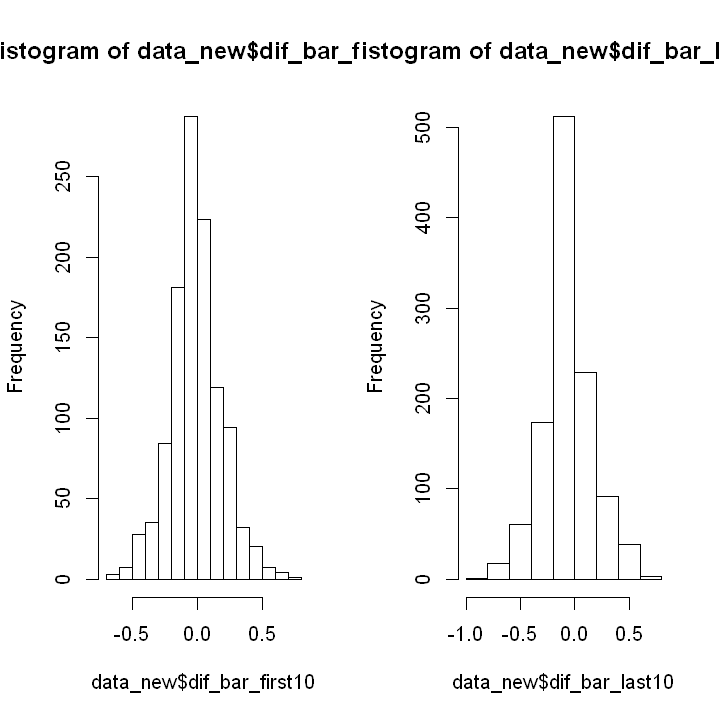

In [43]:
# get dif_bar_first10, dif_bar_last15
NN <- dim(data)[1]

K_test_mat <- as.matrix(data[, 2:26])
S_test_mat <- as.matrix(data[, 27:51])

# calculate di: S - 0.5K
dif_score_mat <- matrix(0, NN, 25)
dif_score_mat <- S_test_mat - 0.5*K_test_mat

dif_score_first10_mat <- dif_score_mat[,1:10]
dif_score_last10_mat <- dif_score_mat[,15:25]

dif_bar_first10 <- apply(dif_score_first10_mat, 1, mean, na.rm = TRUE)
dif_bar_last10 <- apply(dif_score_last10_mat, 1, mean, na.rm = TRUE)

data_new$dif_bar_first10 <- dif_bar_first10
data_new$dif_bar_last10 <- dif_bar_last10

par(mfrow = c(1, 2))
hist(data_new$dif_bar_first10)
hist(data_new$dif_bar_last10)

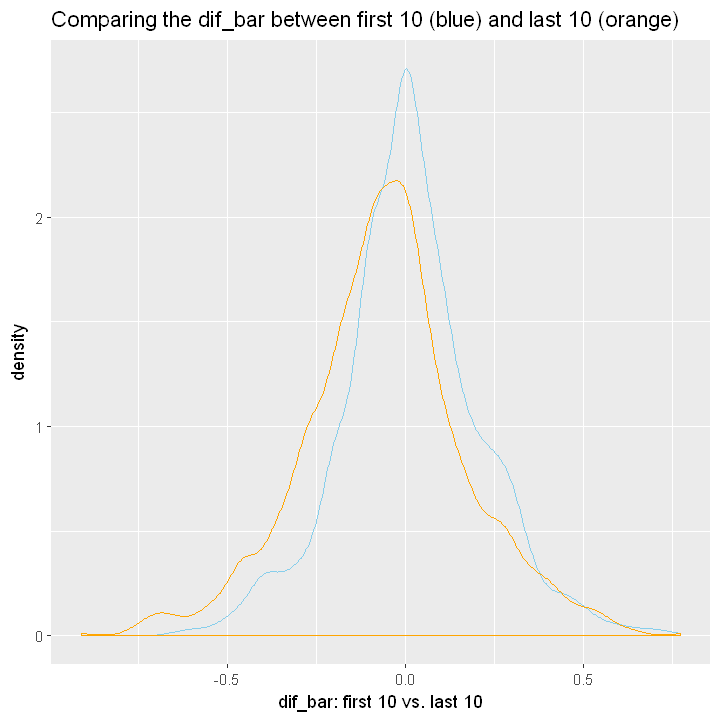

In [44]:
density_compare <- ggplot(data_new, aes(dif_bar_first10)) +
  geom_density(col = "skyblue") + 
  geom_density(aes(dif_bar_last10), data = data_new, col = "orange") +
  xlab("dif_bar: first 10 vs. last 10") +
  ggtitle("Comparing the dif_bar between first 10 (blue) and last 10 (orange)")

density_compare

##### Test if the difference is significant? 
Is the difference significant ?            
$H_0$: $\mu_{10} = \mu_{10}$       
$H_a$: $\mu_{10} \neq \mu_{10}$

In [45]:
# two sample t test 
t.test(dif_bar_first10, dif_bar_last10,
       alternative = "two.sided", var.equal=TRUE)


	Two Sample t-test

data:  dif_bar_first10 and dif_bar_last10
t = 8.176, df = 2248, p-value = 4.848e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.05604214 0.09140836
sample estimates:
  mean of x   mean of y 
 0.01586667 -0.05785859 


p-value = 7.446e-08 < 0.05     
Since p value < 0.05, we reject $H_0$. The difference between the first 10 questions and 15 questions are significant. 

From the graph and the t test, we can conclude that the difference between the first 10 questions and the last 10 questions is significant at 95% confidence level. It may give us some inspiration in detecting random guessing.  

### Correlation Heatmap

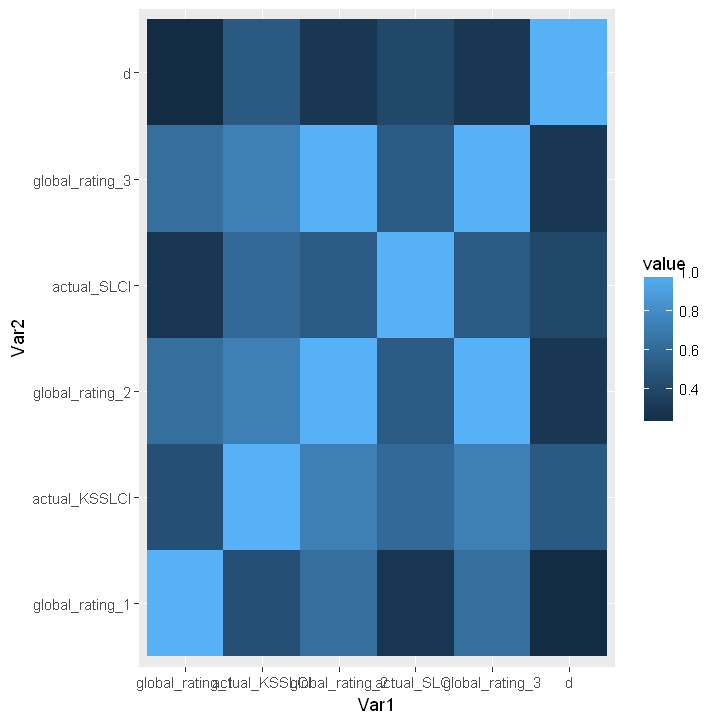

In [46]:
data_cor <- data_new[, 9:14]
qplot(x=Var1, y=Var2, data=melt(abs(cor(data_cor))), fill=value, geom="tile")

The above correlation heatmap illustrate the correlation between the 3 estimations, the knowledge test score, the actual test score and the difference between these two test scores.

The lighter blue represents stronger correlation between the corresponding variables, and the darker color represents weaker correlation between the corresponding variables. 

### SVM 

I also try to use machine learning -- support vector machine to predict whether the students overestimate, underestimate or correctly estimate themselves. Support Vector Machines are an excellent tool for classification, novelty detection, and regression.

**Steps:** 
1. normalise the variables 
2. create the personality variable
3. random sample a training data set, 600
4. check each model's training error 
5. evalute the model with least training error, check the accuracy rate 

I tried polynomial model, Gaussian model, linear kernel, Laplace dot model and Laplacian kernel and check their training error. Among them. The Gaussian model has the lowest training error of 0.45. After evaluating the model with testing data, the accuracy rate is around 0.51, which is higher than random guessing, 0.33. However, this method works, but doesn’t seem to be very effective. 

If you want to see the R documentation for ksvm, click [ksvm](https://www.rdocumentation.org/packages/kernlab/versions/0.9-25/topics/ksvm). 

##### Create a new variable that categorize the dif_bar => Under-estimate, Normal, Over-estimate

In [47]:
sum(data_new$dif_bar > 0.1)    # underestimate
sum(data_new$dif_bar > -0.1 & data_new$dif_bar < 0.1)   
sum(data_new$dif_bar < -0.1)   # overestimate 

[1] 240

[1] 510

[1] 289

In [48]:
data_new$personality <- NULL
data_new$personality[data_new$dif_bar > 0.1] <- "Under-estimate" 
data_new$personality[data_new$dif_bar > -0.1 & data_new$dif_bar < 0.1] <- "Normal" 
data_new$personality[data_new$dif_bar < -0.1] <- "Over-estimate" 

table(data_new$personality)


        Normal  Over-estimate Under-estimate 
           510            289            240 

In [49]:
normalise <- function(x) {
  return((x - min(x)) / (max(x) - min(x)))  # subtract the min value in x and divide by the range of values in x.
}

data_new$Gender <- normalise(as.numeric(data_new$Gender))
data_new$first_generation <- normalise(as.numeric(data_new$first_generation))
data_new$major_science <- normalise(as.numeric(data_new$major_science))
data_new$class_rank <- normalise(as.numeric(data_new$class_rank))
data_new$courses_in_science <- normalise(as.numeric(data_new$courses_in_science))
data_new$english_as_first_language <- normalise(as.numeric(data_new$english_as_first_language))
data_new$Ethnicity <- normalise(as.numeric(data_new$Ethnicity))
data_new$Institution <- normalise(as.numeric(data_new$Institution))

In [50]:
# generate training data 
train <- sample(x = nrow(data_new), size = 600, replace = FALSE) 

##### Polynomial

In [51]:
m_poly <- ksvm(personality ~ Gender + first_generation + major_science + class_rank 
               + courses_in_science + english_as_first_language + Ethnicity + Institution,
          data = data_new[train, ],
          kernel = "polydot", C = 1)

m_poly

 Setting default kernel parameters  


Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Polynomial kernel function. 
 Hyperparameters : degree =  1  scale =  1  offset =  1 

Number of Support Vectors : 489 

Objective Function Value : -296 -272 -228.8845 
Training error : 0.515426 

##### Radial Basis kernel "Gaussian" 

In [52]:
m_rad <- ksvm(personality ~ Gender + first_generation + major_science + class_rank 
               + courses_in_science + english_as_first_language + Ethnicity + Institution,
          data = data_new[train, ],
          kernel = "rbfdot", C = 1)
m_rad

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Gaussian Radial Basis kernel function. 
 Hyperparameter : sigma =  0.115411961064223 

Number of Support Vectors : 498 

Objective Function Value : -279.9903 -250.4338 -196.9958 
Training error : 0.455535 

##### Linear kernel 

In [53]:
m_vanilladot <- ksvm(personality ~ Gender + first_generation + major_science + class_rank 
               + courses_in_science + english_as_first_language + Ethnicity + Institution,
          data = data_new[train, ],
          kernel = "vanilladot", C = 1)
m_vanilladot

 Setting default kernel parameters  


Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Linear (vanilla) kernel function. 

Number of Support Vectors : 493 

Objective Function Value : -296 -272 -228.8845 
Training error : 0.515426 

##### Laplacian kernel 

In [54]:
m_laplacedot <- ksvm(personality ~ Gender + first_generation + major_science + class_rank 
               + courses_in_science + english_as_first_language + Ethnicity + Institution,
          data = data_new[train, ],
          kernel = "laplacedot", C = 1)
m_laplacedot

Support Vector Machine object of class "ksvm" 

SV type: C-svc  (classification) 
 parameter : cost C = 1 

Laplace kernel function. 
 Hyperparameter : sigma =  0.12136258800997 

Number of Support Vectors : 507 

Objective Function Value : -282.96 -256.2679 -211.5326 
Training error : 0.511797 

#### Evaluate the model 

##### Radial Basis kernel "Gaussian" 

In [55]:
pred1 <- predict(m_rad, newdata = data_new[-train, ], type = "response")

confusionMatrix(table(pred1, data_new[-train, "personality"]), positive = "small") 

Confusion Matrix and Statistics

                
pred1            Normal Over-estimate Under-estimate
  Normal            220           126             77
  Over-estimate      11             4              4
  Under-estimate     12            11             23

Overall Statistics
                                          
               Accuracy : 0.5061          
                 95% CI : (0.4608, 0.5514)
    No Information Rate : 0.498           
    P-Value [Acc > NIR] : 0.3757          
                                          
                  Kappa : 0.0804          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: Normal Class: Over-estimate Class: Under-estimate
Sensitivity                 0.9053             0.028369               0.22115
Specificity                 0.1714             0.956772               0.94010
Pos Pred Value              0.5201             0.210526               0.50000
Neg Pred Value              0.6462     

##### laplacedot model 

In [56]:
pred2 <- predict(m_laplacedot, newdata = data_new[-train, ], type = "response")

confusionMatrix(table(pred2, data_new[-train, "personality"]), positive = "small") 

Confusion Matrix and Statistics

                
pred2            Normal Over-estimate Under-estimate
  Normal            242           141            102
  Over-estimate       0             0              0
  Under-estimate      1             0              2

Overall Statistics
                                          
               Accuracy : 0.5             
                 95% CI : (0.4547, 0.5453)
    No Information Rate : 0.498           
    P-Value [Acc > NIR] : 0.4819          
                                          
                  Kappa : 0.0075          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: Normal Class: Over-estimate Class: Under-estimate
Sensitivity               0.995885               0.0000              0.019231
Specificity               0.008163               1.0000              0.997396
Pos Pred Value            0.498969                  NaN              0.666667
Neg Pred Value            0.666667     

It turn out that Radial Basis kernel is the better model. The accuracy rate is around 0.5086. It is higher than random guessing (0.33), but the result is not good enough. 

## Conclusion 

After using bootstrap, we can conclude that people are more likely to overestimate themselves. Our data exhibit support for a Dunny-Kruger Effect. It would be better if we can collect more data of professors and graduate students to be more confident. 

Gender, class rank and science major are significant factors for dif_bar. Also, the difference between the first 10 and last 10 questions is significant. 

We may need more data for professors and graduate students in order to make better conclusion. Also, we may consider include the family income as additional vaiables. 
